In [24]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Preparación de datos

In [25]:
# Descargar precios de cierre (2018-2025)
data = yf.download('AAPL', start='2018-01-01', end='2025-07-02')
data.columns = data.columns.droplevel(1)
prices = data['Close'].values
prices

/tmp/ipython-input-25-967201949.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2018-01-01', end='2025-07-02')
[*********************100%***********************]  1 of 1 completed


array([ 40.42681885,  40.41976929,  40.60754395, ..., 201.08000183,
       205.16999817, 207.82000732])

In [26]:
# Codificar los estados: 0 = baja, 1 = sube
states = (np.diff(prices) > 0).astype(int)
states = np.insert(states, 0, 0)


# Dividir los datos en entrenamiento y pruebas (80% y 20%)
split_ratio = 0.8
split_index = int(split_ratio * len(prices))

train_prices = prices[:split_index]
train_states = states[:split_index]

test_prices = prices[split_index:]
test_states = states[split_index:]


## Entrenamiento con Q-Learning

In [27]:
# Definir espacio de estados y acciones
n_states, n_actions = 2, 3 # Estados: baja o sube el precio; Acciones: Hold, Buy, Sell
np.random.seed(42)
# Hiperparametros
alpha = 0.95 # Tasa de aprendizaje
gamma = 0.40 # Factor de descuento
epsilon = 0.4 # Probabilidad de exploración
episodes = 3000 # Número de episodios de entrenamiento
initial_capital = 10_000 # Capital inicial

# Inicializar Q-table
Q = np.zeros((n_states, n_actions))

# Listas de seguimiento
episode_rewards = []
portfolio_history = []


# Entrenamiento por episodios
for ep in range(episodes):
    cash = initial_capital
    shares = 0
    buy_price = 0
    total_reward = 0

    for t in range(len(train_prices) - 1):
        s = train_states[t]
        current_price = train_prices[t+1]

        # Politica e-greedy
        if np.random.rand() < epsilon:
            a = np.random.choice(n_actions)
        else:
            a = np.argmax(Q[s, :])

        reward = 0

        # Simular el entorno
        if a == 1 and shares == 0 and cash >= current_price:
            shares = int(cash / current_price)
            cash -= shares * current_price
            buy_price = current_price
        elif a == 2 and shares > 0:
            cash += shares * current_price
            reward = (current_price - buy_price) * shares
            shares = 0
            buy_price = 0

        # Valor actual del portafolio
        portfolio_value = cash + shares * current_price

        # Actualizar Q-table
        s_next = train_states[t+1]
        Q[s, a] += alpha * (reward + gamma * np.max(Q[s_next, :]) - Q[s, a])

        total_reward += reward

    # Guardar los reasultados del episodio
    final_portfolio = cash + shares * train_prices[-1]
    episode_rewards.append(total_reward)
    portfolio_history.append(final_portfolio)

## Pasos de aprendizaje

1. El agente observa el estado actual (si el precio sube o el precio baja)

2. Elige una acción (comprar, vender o mantener) usando la política e-greedy:
*   Algunas veces explora (elige al azar), otras veces explota (elige la acción con mayor valor en la Q-table para ese estado).

3. Realiza una acción y observa el resultado.
*  Si vende, calcula la ganancia o pérdida y asigna ese valor como reward (recompensa).
*  Si solo compra o mantiene, la recompensa es 0.

4.  Actualiza la Q-table usando la fórmula de Q-Learning (algóritmo clásico). Ajusta el valor de la acción que tomo en ese estado según la recompensa recibida y lo mejor que puede hacer en el siguiente estado.

5. Repite estqo a lo largo de n numero de episodios sobre los datos históricos de precios, en teoría, mejorando la Q-table cada vez.

Con el tiempo, el agente aprende que acción tomar en cada estado para maximizar su recompensa total (es decir, cómo operar para obtener más ganancias).




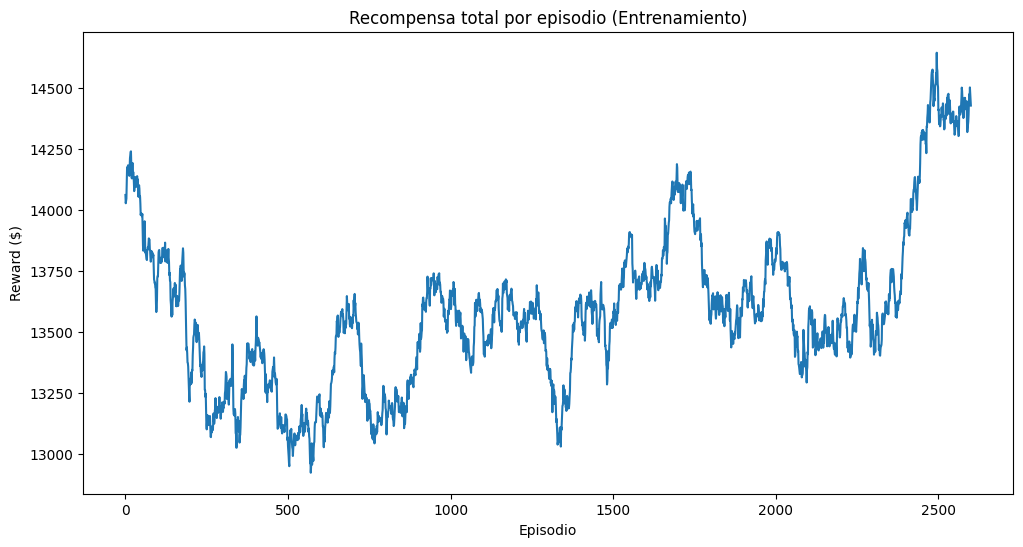

In [31]:
# Graficar desempeño en entrenamiento
window = 400
plt.figure(figsize=(12, 6))
plt.plot(np.convolve(episode_rewards, np.ones(window)/window, mode='valid'))
#plt.plot(episode_rewards)
plt.title('Recompensa total por episodio (Entrenamiento)')
plt.xlabel('Episodio')
plt.ylabel('Reward ($)')
plt.show()

## Backtesting con política e-greedy

-------- Backtesting ---------
Retorno Q-Learning: 12.70%
Retorno Buy & Hold: 8.13%
Diferencia: 4.56%


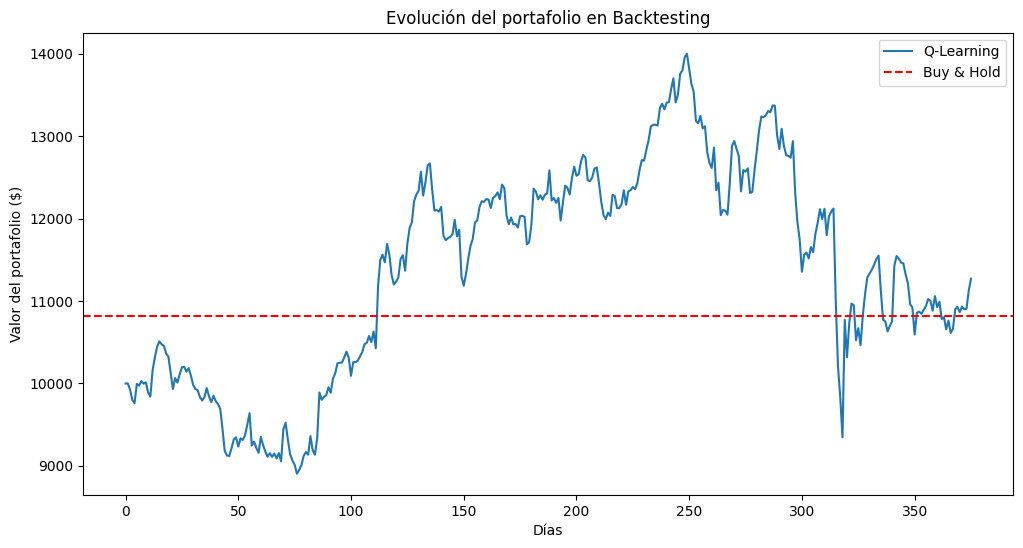

In [30]:
initial_capital = 10000
cash = initial_capital
shares = 0
buy_price = 0
backtest_values = []

# Evaluar la política del agente sin exploración
for t in range(len(test_prices) - 1):
      s = test_states[t]
      current_price = test_prices[t+1]

      # Politica e-greedy
      a = np.argmax(Q[s, :])

      # Simular el entorno
      if a == 1 and shares == 0 and cash >= current_price:
          shares = int(cash / current_price)
          cash -= shares * current_price
          buy_price = current_price
      elif a == 2 and shares > 0:
          cash += shares * current_price
          shares = 0
          buy_price = 0

      # Registrar el valor actual del portafolio
      backtest_values.append(cash + shares * current_price)

# Valor final del portafolio después del backtest
final_backtest_value = cash + shares * test_prices[-1]
backtest_return = (final_backtest_value - initial_capital - 1) / initial_capital * 100

# Comparación contrario estrategia Buy & Hold
buy_hold_shares = initial_capital / test_prices[0]
buy_hold_value = buy_hold_shares * test_prices[-1]
buy_hold_return = (buy_hold_value - initial_capital - 1) / initial_capital * 100

# Mostrar resultados finales
print("-------- Backtesting ---------")
print("==============================")
print(f"Retorno Q-Learning: {backtest_return:.2f}%")
print(f"Retorno Buy & Hold: {buy_hold_return:.2f}%")
print(f"Diferencia: {backtest_return - buy_hold_return:.2f}%")
print("==============================")

# Gráficar evolución del portafolio en backtest
plt.figure(figsize=(12, 6))
plt.plot(backtest_values, label='Q-Learning')
plt.axhline(y=buy_hold_value, color='r', linestyle='--', label='Buy & Hold')
plt.title('Evolución del portafolio en Backtesting')
plt.xlabel('Días')
plt.ylabel('Valor del portafolio ($)')
plt.legend()
plt.show()
